In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -qq '/content/drive/MyDrive/빅프/데이터집/All-Age-Faces Dataset.zip'

In [ ]:
!unzip -qq '/content/drive/MyDrive/빅프/데이터집/archive.zip'

In [ ]:
pip install tensorflow-gpu==2.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 498.4 MB 21 kB/s 
     |████████████████████████████████| 462 kB 67.5 MB/s 
     |████████████████████████████████| 5.8 MB 57.7 MB/s 
     |████████████████████████████████| 1.4 MB 64.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of th

# 전처리

In [ ]:
import pandas as pd
import numpy as np
import glob
import yaml
from IPython.display import Image
from PIL import Image               # to load images
from IPython.display import display # to display images
import os
import cv2
import numpy as np

In [ ]:
from tqdm import tqdm
import time

In [ ]:
kiosk = pd.DataFrame(columns=['age', 'gender', 'x', 'y', 'dx', 'dy','image_path'])

In [ ]:
file_list = os.listdir('/content/All-Age-Faces Dataset/aglined faces')


file_name = []
for file in file_list:
    if file.count(".") == 1: 
        name = file.split('.')[0]
        file_name.append(name)
    else:
        for k in range(len(file)-1,0,-1):
            if file[k]=='.':
                file_name.append(file[:k])
                break
                
# file_name

In [ ]:
for i in range(0,len(file_name)):
    kiosk.loc[i,'image_path']= '/content/All-Age-Faces Dataset/aglined faces' + '/' + file_name[i] + '.jpg'
    kiosk.loc[i,'age']=file_name[i][6:8]
    if i < 7381 :
        kiosk.loc[i,'gender']=0
    else:
        kiosk.loc[i,'gender']=1

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
import plotly.express as px 
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
import matplotlib.pyplot as plt
import pickle

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array

In [ ]:
# from keras.utils import load_img, img_to_array

## main

In [ ]:
df_list = []
for file_name in glob("/content/AdienceBenchmarkGenderAndAgeClassification/*.txt"):
    df_temp = pd.read_csv(file_name, sep="\t")
    df_list.append(df_temp)
df = pd.concat(df_list, axis=0, ignore_index=True)
del df_list

In [ ]:
df = df.dropna()

In [ ]:
df['image_path'] = df[['user_id', 'face_id', 'original_image']].apply(
    lambda x: os.path.join('/content/AdienceBenchmarkGenderAndAgeClassification/faces', f"{x[0]}", f"coarse_tilt_aligned_face.{x[1]}.{x[2]}"), axis=1)

In [ ]:
# pd.set_option('display.max_colwidth', -1)

In [ ]:
def findbucket(age):
    if age>=0 and age<=3:
        return (0,3)
    if age>=4 and age<=7:
        return (4,7)
    if age>=8 and age<=14:
        return (8,14)
    if age>=15 and age<=24:
        return (15,24)
    if age>=25 and age<=37:
        return (25,37)
    if age>=38 and age<=47:
        return (38,47)
    if age>=48 and age<=59:
        return (48,59)
    return (60,100)


def tupleage(agestr):
    split = agestr.split(',')
    a = int(split[0][1:])
    b = int(split[1][1:-1])
    if (a,b) == (0,2):
        return (0,3)
    if (a,b) == (4,6):
        return (4,7)
    if (a,b) == (8,12):
        return (8,14)
    if (a,b) == (15,20):
        return (15,24)
    if (a,b) == (25,32) or (a,b) == (27,32):
        return (25,37)
    if a == 38:
        return (38, 47)
    if (a,b) == (48,53):
        return (48, 59)
    return (a,b)

In [ ]:
df = df[df['age'] != 'None']
df = df[df['age'] != '(8, 23)']
df = df.reset_index(drop=True)
for i in tqdm(range(len(df['age']))):
    if not df['age'][i][0] == '(':
        df['age'][i] = findbucket(int(df['age'][i]))
    else:
        df['age'][i] = tupleage(df['age'][i])

  0%|          | 0/18550 [00:00<?, ?it/s]<ipython-input-19-7a011d2b6659>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'][i] = tupleage(df['age'][i])
<ipython-input-19-7a011d2b6659>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'][i] = findbucket(int(df['age'][i]))
100%|██████████| 18550/18550 [00:09<00:00, 1995.28it/s]


In [ ]:
df['age'].unique()

array([(60, 100), (48, 59), (4, 7), (38, 47), (8, 14), (15, 24), (25, 37),
       (0, 3)], dtype=object)

In [ ]:
new_df = df[df['gender'] != 'u'][['age', 'gender', 'x', 'y', 'dx', 'dy','image_path']]

In [ ]:
del df

In [ ]:
for i in tqdm(range(len(kiosk['age']))):
    if not kiosk['age'][i][0] == '(':
        kiosk['age'][i] = findbucket(int(kiosk['age'][i]))
    else:
        kiosk['age'][i] = tupleage(kiosk['age'][i])

100%|██████████| 13322/13322 [00:03<00:00, 3424.02it/s]


In [ ]:
new_df['gender'] = new_df['gender'].apply(lambda x : 1 if x == 'm' else 0).astype(np.float32)

In [ ]:
kiosk['gender'] = kiosk['gender'].astype(np.float32)

In [ ]:
kiosk = kiosk[['age','gender','image_path']]

In [ ]:
new_df = new_df[['age','gender','image_path']]

In [ ]:
new_df = pd.concat([new_df,kiosk])

In [ ]:
new_df = new_df.reset_index(drop=True)

In [ ]:
new_df['age'] = new_df['age'].astype(str)

In [ ]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
new_df['age'] = le.fit_transform(new_df['age'])

In [ ]:
display(le.classes_)

array(['(0, 3)', '(15, 24)', '(25, 37)', '(38, 47)', '(4, 7)', '(48, 59)',
       '(60, 100)', '(8, 14)'], dtype=object)

In [ ]:
with open('age_encoder.pkl','wb') as pkl_file:
    pickle.dump(le, pkl_file)

## gender

In [ ]:
X = new_df[['image_path']].values 
y = new_df[['gender']].values 

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def preprocess_image(individual_path):
    img = tf.io.read_file(np.array(individual_path).ravel()[0]) 
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128,128])
    return img 

In [ ]:
def yield_training_values(X_train,y_train):
    for image_path, value in zip(X_train, y_train):
        image = preprocess_image(image_path)
        yield image, value 

In [ ]:
ds_train = tf.data.Dataset.from_generator(yield_training_values,
                                          args=[X_train, y_train],
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=([128, 128, 3], [1]))


ds_test = tf.data.Dataset.from_generator(yield_training_values,
                                          args=[X_test, y_test],
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=([128, 128, 3], [1]))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.cache().shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=AUTOTUNE)

In [ ]:
inputs = tf.keras.Input(shape = (128,128,3))
x = Conv2D(128, 3, activation='relu')(inputs)
x = MaxPool2D((2,2))(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(32,(3), activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(32,(3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(2, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics='accuracy')

In [ ]:
history = model.fit(ds_train, validation_data=ds_test,epochs=50)

Epoch 1/50
770/770 [==============================] - 174s 216ms/step - loss: 0.8018 - accuracy: 0.5148 - val_loss: 0.7385 - val_accuracy: 0.5425
Epoch 2/50
770/770 [==============================] - 33s 43ms/step - loss: 0.7147 - accuracy: 0.5199 - val_loss: 0.8353 - val_accuracy: 0.5017
Epoch 3/50
770/770 [==============================] - 35s 45ms/step - loss: 0.7147 - accuracy: 0.5182 - val_loss: 0.8728 - val_accuracy: 0.5461
Epoch 4/50
770/770 [==============================] - 35s 45ms/step - loss: 0.7089 - accuracy: 0.5274 - val_loss: 0.7495 - val_accuracy: 0.4554
Epoch 5/50
770/770 [==============================] - 34s 44ms/step - loss: 0.7071 - accuracy: 0.5207 - val_loss: 1.0748 - val_accuracy: 0.5462
Epoch 6/50
770/770 [==============================] - 34s 44ms/step - loss: 0.7046 - accuracy: 0.5295 - val_loss: 2.1891 - val_accuracy: 0.4580
Epoch 7/50
770/770 [==============================] - 34s 44ms/step - loss: 0.7037 - accuracy: 0.5231 - val_loss: 0.6868 - val_accurac

In [ ]:
model.save('genderbase.h5')

## age

In [ ]:
X = new_df[['image_path']].values
y = new_df[['age']].values

def yield_training_values(X_train,y_train):
    for image_path, value in zip(X_train, y_train):
        image = preprocess_image(image_path)
        yield image, value 
        
def preprocess_image(individual_path):
    img = tf.io.read_file(np.array(individual_path).ravel()[0]) 
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128,128])
    return img 
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2,0.2),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    tf.keras.layers.Rescaling(1./255)
])

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
ds_train = tf.data.Dataset.from_generator(yield_training_values,
                                          args=[X_train, y_train],
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=([128, 128, 3], [1]))


ds_test = tf.data.Dataset.from_generator(yield_training_values,
                                          args=[X_test, y_test],
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=([128, 128, 3], [1]))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.cache().shuffle(buffer_size=100).batch(32).prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().shuffle(buffer_size=100).batch(32).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# keras.backend.clear_session()

In [ ]:
inputs = tf.keras.Input(shape = (128,128,3))
x = data_augmentation(inputs)
x = Conv2D(128, 3, activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2D(64,(3), activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(32,(3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(13, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)



callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics='accuracy')

In [ ]:
history = model.fit(ds_train, validation_data=ds_test,epochs=100)

Epoch 1/100
818/818 [==============================] - 192s 218ms/step - loss: 2.2579 - accuracy: 0.2692 - val_loss: 1.9739 - val_accuracy: 0.3293
Epoch 2/100
818/818 [==============================] - 38s 46ms/step - loss: 1.9756 - accuracy: 0.3107 - val_loss: 1.9613 - val_accuracy: 0.3406
Epoch 3/100
818/818 [==============================] - 37s 45ms/step - loss: 1.9238 - accuracy: 0.3198 - val_loss: 2.0364 - val_accuracy: 0.2879
Epoch 4/100
818/818 [==============================] - 37s 45ms/step - loss: 1.8881 - accuracy: 0.3285 - val_loss: 1.8575 - val_accuracy: 0.3312
Epoch 5/100
818/818 [==============================] - 37s 45ms/step - loss: 1.8715 - accuracy: 0.3325 - val_loss: 1.8899 - val_accuracy: 0.3276
Epoch 6/100
818/818 [==============================] - 37s 45ms/step - loss: 1.8448 - accuracy: 0.3371 - val_loss: 1.8100 - val_accuracy: 0.3473
Epoch 7/100
818/818 [==============================] - 38s 46ms/step - loss: 1.8172 - accuracy: 0.3424 - val_loss: 1.8479 - val_

In [ ]:
model.save('agebase.h5')

# 실행

In [ ]:
from keras.models import load_model
model_age = load_model('/content/drive/MyDrive/빅프/기타/agebase.h5')

In [ ]:
le.classes_

array(['(0, 3)', '(15, 24)', '(25, 37)', '(38, 47)', '(4, 7)', '(48, 59)',
       '(60, 100)', '(8, 14)'], dtype=object)

In [ ]:
def change(a):
    for i, j in enumerate(le.classes_):
        if a.argmax() == i:
            b  = j
    return b

In [ ]:
img = Image.open('/content/drive/MyDrive/빅프/사진/이순재.jfif')
img_resize = img.resize((128, 128))
pixels = np.array(img_resize)
pixel = pixels.reshape(1,128,128,3)
a = model_age.predict(pixel)

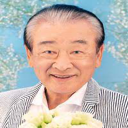

'(60, 100)'

In [ ]:
display(img_resize)
change(a)